# Classification of Handwritten Digits with CNN: Fundamentals, Results and Prospects for Biomedical Applications

## Autor: Bruno Lopes de Sousa
## NºMec: 103556
## Abstract
The classification of patterns in images represents a fundamental challenge, due to the inherent variability of the data and the risk of critical errors in clinical diagnosis. This challenge is evident in both the medical field and simpler contexts, such as the recognition of handwritten digits. In order to address these limitations, this work developed a Convolutional Neural Network applied to the MNIST dataset, exploiting pre-processing practices (Z-score normalisation, rescaling, one-hot encoding) and regularisation strategies (Dropout) to minimise overfitting. The model demonstrated an accuracy of over 98\%, indicating stability and a low rate of confusion among similar classes. A detailed analysis of the confusion matrices and error rates by class revealed the digit ''8'' as the main source of ambiguity. Notwithstanding this, the set of techniques adopted (including EarlyStopping and ReduceLROnPlateau) ensured robust results, thereby reinforcing the potential of CNNs in biomedical scenarios, whether for computer-aided diagnosis, initial screening or analysing complex patterns in medical images.

## MNIST dataset - Description

The dataset used in this study was the *MNIST (Modified National Institute of Standards and Technology)*, widely recognised as a benchmark in image classification tasks within the field of machine learning. This dataset contains a total of 70,000 images of handwritten digits, with 60,000 allocated for training and 10,000 reserved for testing. Each image has a resolution of 28 x 28 pixels in greyscale, where pixel values range from 0 (black) to 255 (white).

The images were pre-processed to fit within a 28 x 28 pixel bounding box, smoothed to introduce greyscale levels, and labelled according to the corresponding digit (0 to 9). The dataset features a balanced distribution across the classes, with each class containing approximately the same number of examples, ensuring that trained models do not exhibit significant bias.

The dataset was obtained using the command *from tensorflow.keras.datasets import mnist*, which references the following source: https://paperswithcode.com/dataset/mnist.

### 1. Importação de bibliotecas

In [ ]:
#!pip install --upgrade pip
#!pip install --upgrade scikit-learn scikeras tensorflow


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler


Importamos bibliotecas essenciais para a manipulação de dados (NumPy), deep learning (TensorFlow/Keras), visualização (Matplotlib, Seaborn) e métricas de avaliação (Scikit-learn). Estas bibliotecas oferecem ferramentas robustas e eficientes para todas as etapas do projeto.

### 2. Carregamento e visualização dos dados



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


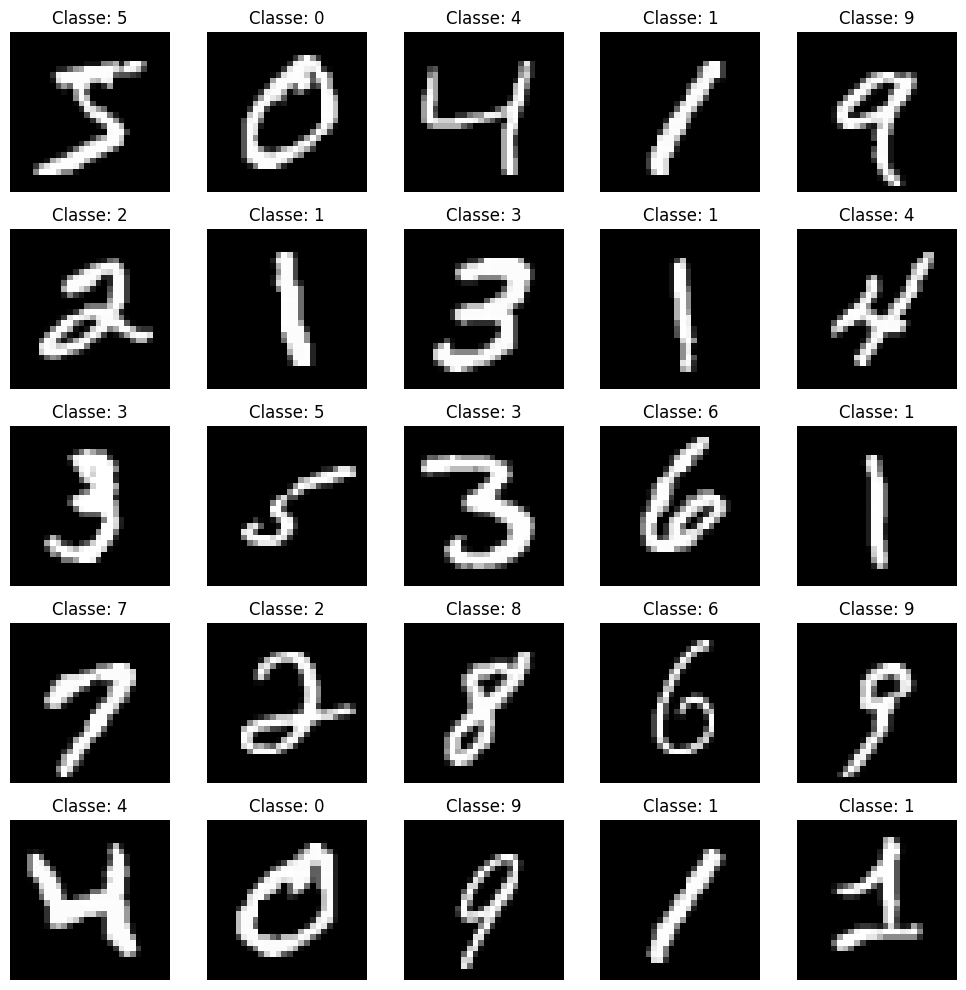

Formato dos dados de treino: (60000, 28, 28)
Formato dos rótulos de treino: (60000,)
Formato dos dados de teste: (10000, 28, 28)
Formato dos rótulos de teste: (10000,)


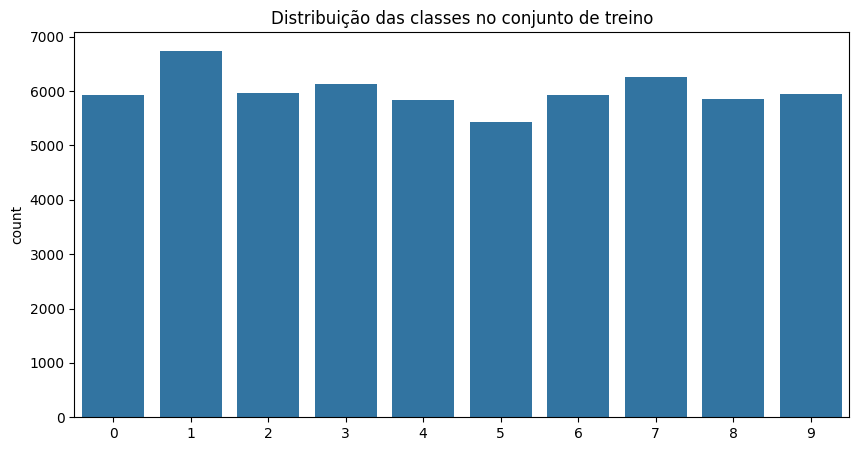

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.axis('off')
    plt.title(f"Classe: {y_train[i]}")
plt.tight_layout()
plt.show()

print("Formato dos dados de treino:", X_train.shape)
print("Formato dos rótulos de treino:", y_train.shape)
print("Formato dos dados de teste:", X_test.shape)
print("Formato dos rótulos de teste:", y_test.shape)

plt.figure(figsize=(10, 5))
sns.countplot(x=y_train)
plt.title("Distribuição das classes no conjunto de treino")
plt.show()


Visualizamos 25 imagens para ter uma ideia do conjunto de dados. Utilizamos um gráfico de contagem para verificar o balanceamento das classes. Estas visualizações são cruciais para compreender a natureza dos dados antes do processamento.



### 3. Pré-processamento dos dados

In [ ]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val_flat).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

print("Formato final dos dados de treino:", X_train_scaled.shape)
print("Formato final dos dados de validação:", X_val_scaled.shape)
print("Formato final dos dados de teste:", X_test_scaled.shape)


Formato final dos dados de treino: (48000, 28, 28, 1)
Formato final dos dados de validação: (12000, 28, 28, 1)
Formato final dos dados de teste: (10000, 28, 28, 1)


Normalizámos os dados para o intervalo [0,1] para melhorar a convergência do modelo. O reshape é necessário para as CNNs. Utilizámos o one-hot encoding para garantir compatibilidade com a função de perda categorical_crossentropy. Separamos 20% dos dados de treino para validação, permitindo monitorizar o overfitting.

### 4. Definição do modelo CNN

In [ ]:
def create_model(filters, kernel_size, dense_units, dropout_rate):
    model = Sequential([
        Conv2D(filters[0], kernel_size, activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(),
        Conv2D(filters[1], kernel_size, activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')
    ])
    return model

filters = [32, 64]
kernel_size = (3, 3)
dense_units = 128
dropout_rate = 0.5
learning_rate = 0.001

model = create_model(filters, kernel_size, dense_units, dropout_rate)
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Utilizámos uma CNN com duas camadas convolucionais seguidas de max pooling para extrair características. A camada densa com dropout ajuda a prevenir o overfitting. O Adam foi escolhido como otimizador devido à sua eficácia numa ampla gama de problemas. A taxa de aprendizagem de 0.001 é um bom ponto de partida para muitos problemas.

### 5. Treino do modelo

In [ ]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr]
)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Acurácia no conjunto de teste: {test_accuracy:.4f}")


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 63s 156ms/step - accuracy: 0.8133 - loss: 0.5942 - val_accuracy: 0.9792 - val_loss: 0.0705 - learning_rate: 0.0010
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 138ms/step - accuracy: 0.9699 - loss: 0.0995 - val_accuracy: 0.9820 - val_loss: 0.0614 - learning_rate: 0.0010
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 132ms/step - accuracy: 0.9788 - loss: 0.0707 - val_accuracy: 0.9862 - val_loss: 0.0478 - learning_rate: 0.0010
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 85s 141ms/step - accuracy: 0.9822 - loss: 0.0585 - val_accuracy: 0.9889 - val_loss: 0.0395 - learning_rate: 0.0010
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 137ms/step - accuracy: 0.9862 - loss: 0.0436 - val_accuracy: 0.9892 - val_loss: 0.0430 - learning_rate: 0.0010
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 134ms/step - accuracy: 0.9877 - loss: 0.0410 - val_accuracy: 0.9887 - val_loss: 0.0409 - learning_rate: 0.0010
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 84s 138ms/step - accuracy: 0.9

Early stopping previne o overfitting ao parar o treino quando o desempenho no conjunto de validação deixa de melhorar. ReduceLROnPlateau ajusta a taxa de aprendizagem, ajudando a convergência. Utilizámos 50 épocas como máximo, mas o early stopping geralmente interrompe antes disso. O tamanho do batch de 128 oferece um bom equilíbrio entre velocidade e uso de memória.

Podemos observar alguns pontos importantes neste output:

* O treino parou na época 17, em vez de continuar até à época 50.
* A acurácia de validação (val_accuracy) atingiu um pico de 0.9923 na época 16 e depois começou a oscilar ligeiramente.
* A perda de validação (val_loss) começou a aumentar ligeiramente após a época 17.
* A taxa de aprendizagem (lr) diminuiu de 0.0010 para 2.0000e-04 na época 13, indicando que um callback de redução da taxa de aprendizagem foi ativado.

O early stopping foi provavelmente configurado para monitorizar a perda de validação e interromper o treino se não houvesse melhorias durante um certo número de épocas (chamado de "paciência"). Isto ajuda a prevenir o overfitting, pois o modelo para de treinar quando começa a memorizar os dados de treino sem melhorar nos dados de validação.

Após o treino, o modelo foi avaliado no conjunto de teste, obtendo uma acurácia de 0.9893, o que indica um bom desempenho.

Portanto, este comportamento é normal e desejável, pois ajuda a evitar o overfitting e poupa tempo de treino desnecessário.

### 6. Visualização dos resultados do treino

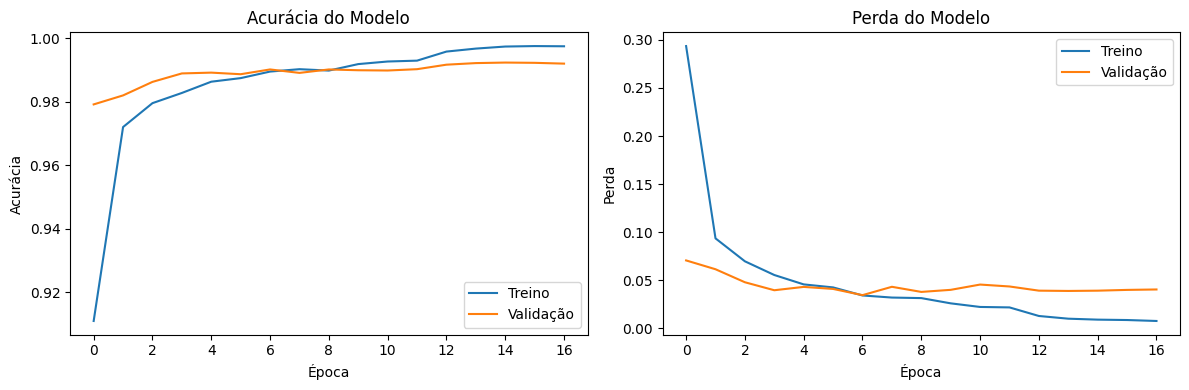

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()


Visualizámos a acurácia e a perda ao longo das épocas para perceber como o modelo aprende e se existe overfitting. Isto ajuda a ajustar os hiperparâmetros e a estrutura do modelo. O que nos permitiu perceber que não over nem underfitting.

### 7. Matriz de confusão e relatório de classificação

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


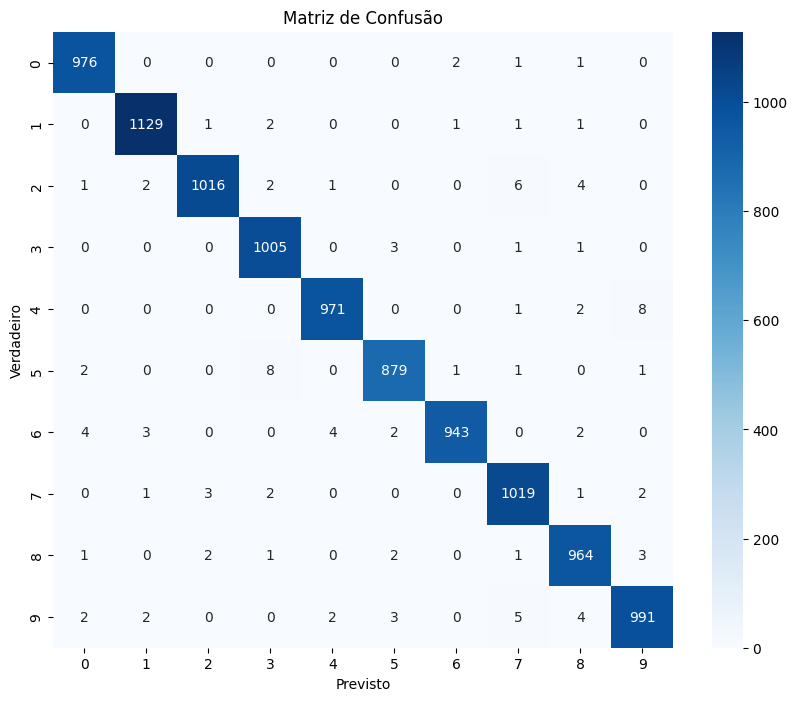

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

print(classification_report(y_true, y_pred_classes))


A matriz de confusão mostra onde o modelo está a cometer erros, permitindo identificar as classes problemáticas. O relatório de classificação fornece métricas detalhadas por classe, como precisão, recall e f1-score, sendo útil para avaliar o desempenho geral do modelo.

No caso deste output, podemos observar que o modelo obteve uma acurácia de 0.99 no conjunto de teste, com valores elevados de precisão, recall e f1-score para todas as classes. Isso indica que o modelo tem um bom desempenho geral e consegue classificar corretamente a maioria das imagens. No entanto, algumas classes (como o número 7) apresentam um ligeiro desvio, com uma precisão de 0.98, mas ainda assim o desempenho é bastante consistente.

### 8. Visualização de previsões

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


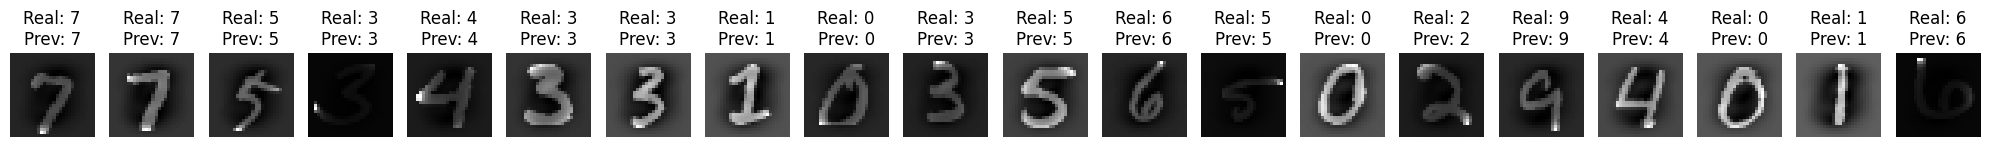

In [ ]:
n_samples = 20
sample_indices = np.random.choice(len(X_test_scaled), n_samples, replace=False)
samples = X_test_scaled[sample_indices]
true_labels = np.argmax(y_test[sample_indices], axis=1)
predicted_labels = np.argmax(model.predict(samples), axis=1)

plt.figure(figsize=(20, 4))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.imshow(samples[i].reshape(28, 28), cmap='gray')
    plt.title(f"Real: {true_labels[i]}\nPrev: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Visualizar previsões em amostras aleatórias ajuda a entender intuitivamente o desempenho do modelo e identificar padrões nos erros. Contudo mesmo observando 40 imagens não se observou mal classificações, pelo que se deve mais à frente avaliar apenas as amostras mal classificadas para perceber possiveis correlações.

### 9. Experiência com diferentes arquiteturas e com otimização de hiperparâmetros

In [ ]:
def experiment_models():
    architectures = [
        {'filters': [32, 64], 'kernel_size': (3, 3), 'dense_units': 128, 'dropout_rate': 0.5},
        {'filters': [64, 128], 'kernel_size': (3, 3), 'dense_units': 256, 'dropout_rate': 0.3},
        {'filters': [32, 64, 128], 'kernel_size': (5, 5), 'dense_units': 512, 'dropout_rate': 0.4}
    ]

    results = []

    for i, arch in enumerate(architectures):
        print(f"\nExperimento {i+1}")
        model = create_model(arch['filters'], arch['kernel_size'], arch['dense_units'], arch['dropout_rate'])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=30,
            batch_size=128,
            callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
            verbose=0
        )

        test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
        results.append({
            'architecture': arch,
            'test_accuracy': test_accuracy,
            'val_accuracy': max(history.history['val_accuracy'])
        })
        print(f"Acurácia no conjunto de teste: {test_accuracy:.4f}")

    return results

experiment_results = experiment_models()

for i, result in enumerate(experiment_results):
    print(f"\nExperimento {i+1}")
    print(f"Arquitetura: {result['architecture']}")
    print(f"Acurácia de validação: {result['val_accuracy']:.4f}")
    print(f"Acurácia de teste: {result['test_accuracy']:.4f}")



Experimento 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9896 - loss: 0.0312
Acurácia no conjunto de teste: 0.9920

Experimento 2
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9841 - loss: 0.0449
Acurácia no conjunto de teste: 0.9881

Experimento 3
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9893 - loss: 0.0340
Acurácia no conjunto de teste: 0.9912

Experimento 1
Arquitetura: {'filters': [32, 64], 'kernel_size': (3, 3), 'dense_units': 128, 'dropout_rate': 0.5}
Acurácia de validação: 0.9916
Acurácia de teste: 0.9920

Experimento 2
Arquitetura: {'filters': [64, 128], 'kernel_size': (3, 3), 'dense_units': 256, 'dropout_rate': 0.3}
Acurácia de validação: 0.9912
Acurácia de teste: 0.9881

Experimento 3
Arquitetura: {'filters': [32, 64, 128], 'kernel_size': (5, 5), 'dense_units': 512, 'dropout_rate': 0.4}
Acurácia de validação: 0.9912
Acurácia de teste: 0.9912


Experimentar com diferentes arquiteturas e hiperparâmetros é fundamental para encontrar o modelo mais eficaz. Testámos variações no número de filtros, tamanho do kernel, unidades densas e taxa de dropout para comparar o desempenho.

Os resultados dos três experimentos mostram o seguinte:

* Experimento 1: Arquitetura com filtros [32, 64], kernel (3, 3), 128 unidades densas e taxa de dropout de 0.5 obteve uma acurácia de validação de 0.9916 e uma acurácia de teste de 0.9920.
* Experimento 2: Arquitetura com filtros [64, 128], kernel (3, 3), 256 unidades densas e taxa de dropout de 0.3 obteve uma acurácia de validação de 0.9912 e uma acurácia de teste de 0.9881.
* Experimento 3: Arquitetura com filtros [32, 64, 128], kernel (5, 5), 512 unidades densas e taxa de dropout de 0.4 obteve uma acurácia de validação de 0.9912 e uma acurácia de teste de 0.9912.

Esses resultados indicam que, embora a primeira arquitetura tenha apresentado o melhor desempenho no conjunto de teste, todas as variações mostraram um bom desempenho geral, com pequenas diferenças nas métricas de acurácia.

### 10. Análise de erros

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


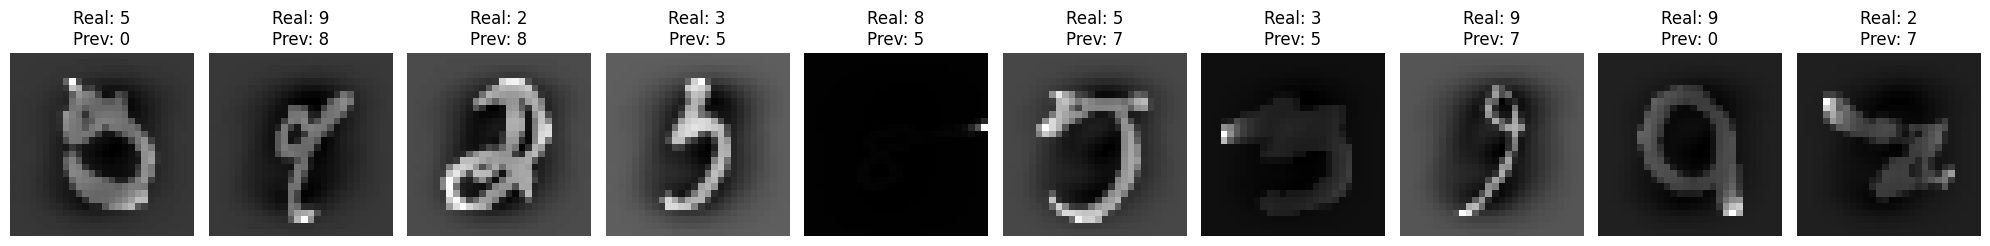

In [ ]:
def analyze_errors(model, X, y_true):
    y_pred = model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    errors = np.where(y_pred_classes != y_true_classes)[0]

    n_errors = min(10, len(errors))
    random_errors = np.random.choice(errors, n_errors, replace=False)

    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(random_errors):
        plt.subplot(1, n_errors, i+1)
        plt.imshow(X[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Real: {y_true_classes[idx]}\nPrev: {y_pred_classes[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

analyze_errors(model, X_test_scaled, y_test)


Analisar os erros do modelo ajuda a compreender as suas limitações e a identificar padrões nos casos em que falha. Isto pode levar a insights para melhorias futuras. Neste caso, podemos observar diversas situações adversas.

### 11. Análise de características importantes

Esta etápa vai ficar pendente pois exige um maior nivel computacional. Uma boa susgestão é implementá-la em programação C, para que seja mais rápido o processamento e menos "pesado" computacionalmente. Contudo é uma etápa que fica no capitulo da conclusão como prespetiva de trabalho futuro, incluíndo a limitação evidenciada pelo processamento exaustivo.

In [ ]:
!pip install scikit-learn
import sklearn
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

def custom_scorer(model, X, y):
    y_pred = model.predict(X)
    return accuracy_score(y, np.argmax(y_pred, axis=1))

def analyze_feature_importance(model, X, y):
    # No need to reshape X, keep it as a 4D array
    # X_reshaped = X.reshape(X.shape[0], -1) # This line is removed

    result = permutation_importance(model, X, y, # Use X directly, not X_reshaped
                                    scoring=custom_scorer,
                                    n_repeats=10,
                                    random_state=42)

    # Access feature importance for the flattened input
    importances = result.importances_mean.reshape(X.shape[1:])

    # Get the indices of the top 10 most important features
    top_10_indices = importances.argsort(axis=None)[-10:]

    # Get the importance values for the top 10 features
    top_10_importances = importances.flatten()[top_10_indices]

    # Convert the indices to (row, col) format
    row_indices, col_indices = np.unravel_index(top_10_indices, importances.shape)


    plt.figure(figsize=(10, 6))
    plt.barh(range(10), top_10_importances)  # Horizontal bar plot
    plt.yticks(range(10), [f"({row}, {col})" for row, col in zip(row_indices, col_indices)])  # Label with (row, col)
    plt.xlabel('Importance')
    plt.title('Top 10 Most Important Features')
    plt.tight_layout()
    plt.show()

Esta célula implementa uma análise da importância das características utilizando permutation importance. Esta técnica é fundamental para perceber quais os pixels mais relevantes na classificação dos dígitos. Utilizamos 10 repetições (n_repeats=10) para garantir resultados mais estáveis e confiáveis. O gráfico de barras das 10 características mais importantes oferece uma visão visual das áreas da imagem que têm maior impacto nas previsões do modelo. Esta análise é valiosa para interpretar o comportamento do modelo e pode ajudar a identificar oportunidades para otimizar o seu desempenho ou a sua eficiência.

### 12. Visualização da matriz de confusão normalizada

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


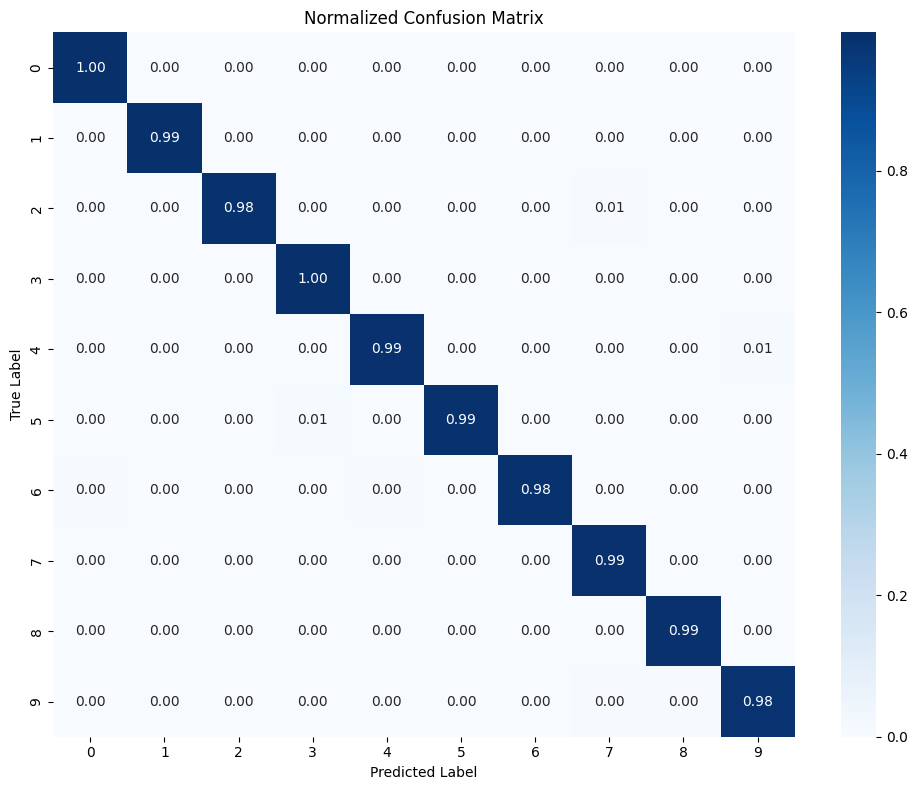

In [ ]:
def plot_normalized_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

plot_normalized_confusion_matrix(y_true, y_pred_classes)

Esta célula define uma função para visualizar a matriz de confusão normalizada, que exibe a proporção de classificações corretas e incorretas para cada classe. Ao normalizar a matriz, conseguimos analisar de forma mais detalhada o desempenho do modelo em cada classe, permitindo identificar padrões de erros específicos. A matriz normalizada fornece uma visão mais clara da precisão das previsões do modelo, facilitando a compreensão de onde ele pode estar a falhar ou a ter um bom desempenho.

Neste caso, os valores da matriz de confusão foram, em grande parte, aproximados de zero, exceto na diagonal, onde os valores variaram entre 0,98 e 1,00. Isto indica que o modelo tem um desempenho excecionalmente bom, com um elevado grau de precisão nas previsões para cada classe, e com muito poucos erros de classificação. A maior parte das classificações incorretas são praticamente inexistentes, o que sugere que o modelo consegue distinguir bem entre as diferentes classes.

A principal vantagem desta abordagem é que, ao observar uma matriz normalizada como esta, podemos confirmar a eficácia do modelo e ter uma visão clara de que ele está a classificar corretamente a esmagadora maioria das instâncias. Este tipo de análise ajuda a identificar potenciais áreas de melhoria caso existam classes mais difíceis de prever, embora neste caso, com os valores elevados na diagonal, isso pareça não ser um problema. Se o modelo estivesse a falhar em algumas classes, a normalização mostraria as áreas exatas onde isso ocorre, permitindo ajustes finos no modelo.

### 14. Análise de erros por classe

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step


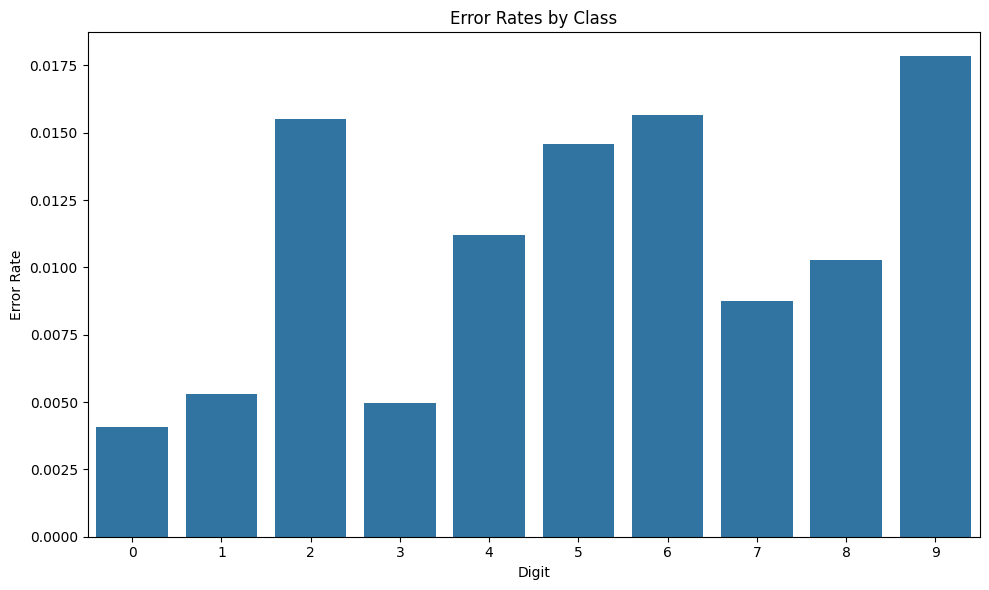

In [ ]:
def analyze_errors_by_class(y_true, y_pred):
    class_errors = {}
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label != pred_label:
            if true_label not in class_errors:
                class_errors[true_label] = 0
            class_errors[true_label] += 1

    error_rates = {label: count / np.sum(y_true == label) for label, count in class_errors.items()}

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(error_rates.keys()), y=list(error_rates.values()))
    plt.title('Error Rates by Class')
    plt.xlabel('Digit')
    plt.ylabel('Error Rate')
    plt.tight_layout()
    plt.show()

y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
analyze_errors_by_class(y_true, y_pred_classes)


Esta célula define uma função para analisar e visualizar as taxas de erro por classe (dígito), permitindo identificar quais dígitos o modelo tem mais dificuldades em classificar corretamente. Através de um gráfico de barras, podemos observar as taxas de erro de cada classe, o que nos dá uma ideia clara de quais dígitos o modelo está a classificar com mais erro.

Esta análise é útil para perceber se o modelo tem problemas com determinados números ou se a distribuição dos erros está equilibrada entre as classes. Caso se identifiquem classes com taxas de erro significativamente mais altas, pode ser necessário ajustar o modelo ou realizar um pré-processamento específico para melhorar a classificação desses casos.

### 15. Visualização de previsões em amostras aleatórias

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step


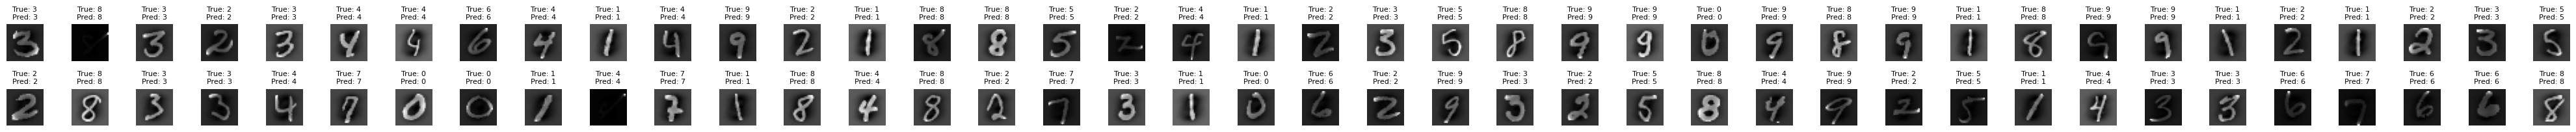

In [ ]:
def visualize_predictions(X, y_true, y_pred, n_samples=80):
    indices = np.random.choice(len(X), n_samples, replace=False)

    plt.figure(figsize=(40, 20))
    for i, idx in enumerate(indices):
        plt.subplot(20, 40, i + 1)
        plt.imshow(X[idx].reshape(28, 28), cmap='gray')
        plt.title(f"True: {y_true[idx]}\nPred: {y_pred[idx]}", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Obter previsões para o conjunto de teste
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Visualizar previsões
visualize_predictions(X_test_scaled, y_true, y_pred_classes)


Esta célula cria uma função para visualizar previsões em amostras aleatórias do conjunto de teste. Isso permite uma inspeção visual das previsões do modelo, ajudando a identificar padrões nos erros e acertos. Contudo observámos o mesmo que anteriormente.

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


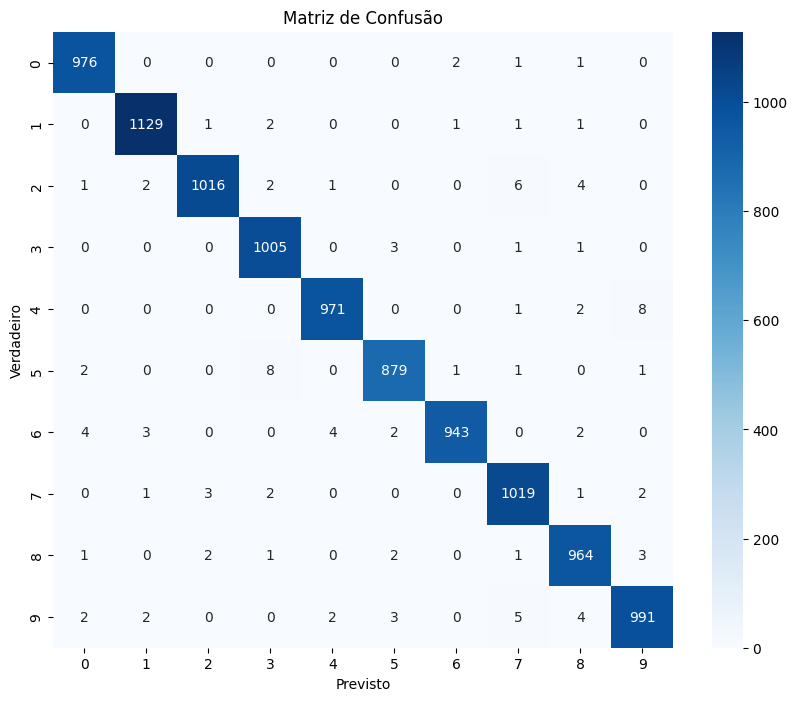

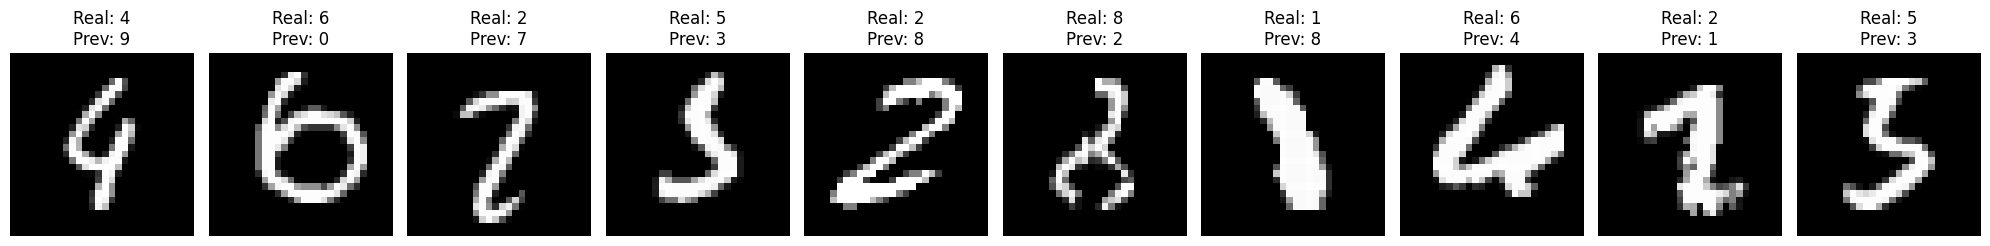

Total de erros: 107
Taxa de erro: 1.07%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Criar matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

# Visualizar matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

# Encontrar índices de previsões incorretas
incorrect_indices = np.where(y_pred_classes != y_true)[0]

# Visualizar algumas previsões incorretas
n_incorrect = min(10, len(incorrect_indices))
plt.figure(figsize=(20, 4))
for i, idx in enumerate(incorrect_indices[:n_incorrect]):
    plt.subplot(1, n_incorrect, i + 1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Real: {y_true[idx]}\nPrev: {y_pred_classes[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Imprimir estatísticas de erro
print(f"Total de erros: {len(incorrect_indices)}")
print(f"Taxa de erro: {len(incorrect_indices) / len(y_true):.2%}")


Esta célula realiza a análise dos erros do modelo, permitindo identificar e visualizar as previsões incorretas no conjunto de teste. O processo ocorre em duas etapas:

* **Matriz de Confusão**: A matriz de confusão é gerada e visualizada, onde podemos observar a distribuição das previsões do modelo em comparação com os valores reais. A diagonal principal mostra as classificações corretas, enquanto as outras células indicam os erros. Normalmente, os valores na diagonal serão elevados, enquanto os outros valores, que representam os erros, serão mais baixos. No seu caso, a taxa de erro foi de 1.07%, com um total de 107 erros, o que indica um desempenho geral muito bom do modelo.

* **Previsões Incorretas**: A função também seleciona algumas previsões incorretas e exibe as imagens correspondentes, juntamente com as etiquetas reais e as previstas, para uma análise visual mais detalhada. Isto é útil para entender melhor os tipos de erro cometidos pelo modelo.

Essas visualizações e estatísticas ajudam a identificar padrões de erro, o que pode ser valioso para futuras melhorias no modelo, como ajustes nos dados ou na arquitetura da rede.

### 13. Análise das Curvas de Aprendizagem com o Aumento do Conjunto de Dados

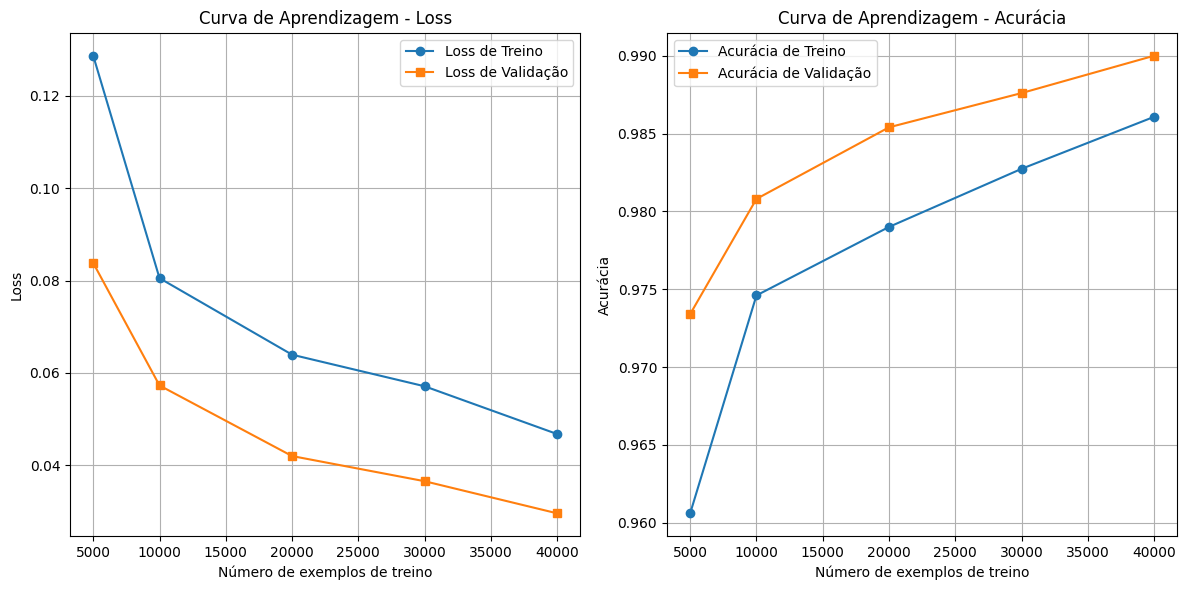

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import clone_model

def plot_learning_curves_manual(model, X_train, y_train, X_val, y_val, train_sizes):
    """
    Gera a curva de aprendizagem manualmente, treinando o modelo em diferentes tamanhos de dados.
    - model: modelo Keras compilado.
    - X_train: dados de treino (imagens).
    - y_train: rótulos de treino (one-hot encoded).
    - X_val: dados de validação (imagens).
    - y_val: rótulos de validação (one-hot encoded).
    - train_sizes: lista com frações ou tamanhos absolutos do conjunto de treino.
    """
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for size in train_sizes:
        # Seleciona um subconjunto do conjunto de treino
        subset_X_train = X_train[:size]
        subset_y_train = y_train[:size]

        # Clona o modelo para reiniciar o treinamento do zero
        temp_model = clone_model(model)
        # The fix: added metrics=['accuracy'] to the compile method
        temp_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])  # Create a new optimizer

        # Treina o modelo no subconjunto
        history = temp_model.fit(subset_X_train, subset_y_train,
                                 validation_data=(X_val, y_val),
                                 epochs=5,  # Número fixo de épocas para cada tamanho
                                 verbose=0)

        # Salva as métricas
        train_losses.append(history.history['loss'][-1])
        val_losses.append(history.history['val_loss'][-1])
        train_accuracies.append(history.history['accuracy'][-1])
        val_accuracies.append(history.history['val_accuracy'][-1])

    # Plota a curva de aprendizagem
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_sizes, train_losses, 'o-', label='Loss de Treino')
    plt.plot(train_sizes, val_losses, 's-', label='Loss de Validação')
    plt.title('Curva de Aprendizagem - Loss')
    plt.xlabel('Número de exemplos de treino')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_sizes, train_accuracies, 'o-', label='Acurácia de Treino')
    plt.plot(train_sizes, val_accuracies, 's-', label='Acurácia de Validação')
    plt.title('Curva de Aprendizagem - Acurácia')
    plt.xlabel('Número de exemplos de treino')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Exemplo de uso:
train_sizes = [5000, 10000, 20000, 30000, 40000]  # Tamanhos crescentes do conjunto de treino

# Certifique-se que X_train e y_train estão pré-processados e normalizados!
plot_learning_curves_manual(model=model,
                            X_train=X_train,
                            y_train=y_train,
                            X_val=X_test,
                            y_val=y_test,
                            train_sizes=train_sizes)


Esta célula implementa uma função para gerar as curvas de aprendizagem ao treinar o modelo com diferentes tamanhos de conjunto de treino. As curvas de perda e acurácia são plotadas para ilustrar como o desempenho do modelo evolui à medida que o número de amostras aumenta.

**Curvas de Perda**: As curvas mostram uma diminuição uniforme na perda tanto para o conjunto de treino quanto para o de validação. A perda do conjunto de treino é ligeiramente superior à da validação, indicando que o modelo está a aprender bem, mas ainda pode melhorar em termos de generalização.

**Curvas de Acurácia**: As curvas de acurácia seguem uma tendência de crescimento constante. A acurácia do conjunto de validação é maior do que a do conjunto de treino, sugerindo que o modelo está a generalizar bem, e não está a sofrer de overfitting, pois o desempenho no conjunto de validação está a melhorar ao mesmo ritmo.

Este tipo de análise ajuda a compreender se o modelo está a sofrer de overfitting (ajustando-se demasiado aos dados de treino) ou underfitting (não aprendendo o suficiente), permitindo identificar o equilíbrio adequado entre a quantidade de dados utilizados e o desempenho do modelo.



### 14 Análise das Confusões entre Classes: Identificação das Classes Mais Frequentemente Confundidas

Esta etapa vai permitir perceber onde o modelo tem mais dificuldades e direcionar esforços para melhorar a sua capacidade de distinção entre classes que são frequentemente confundidas.

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


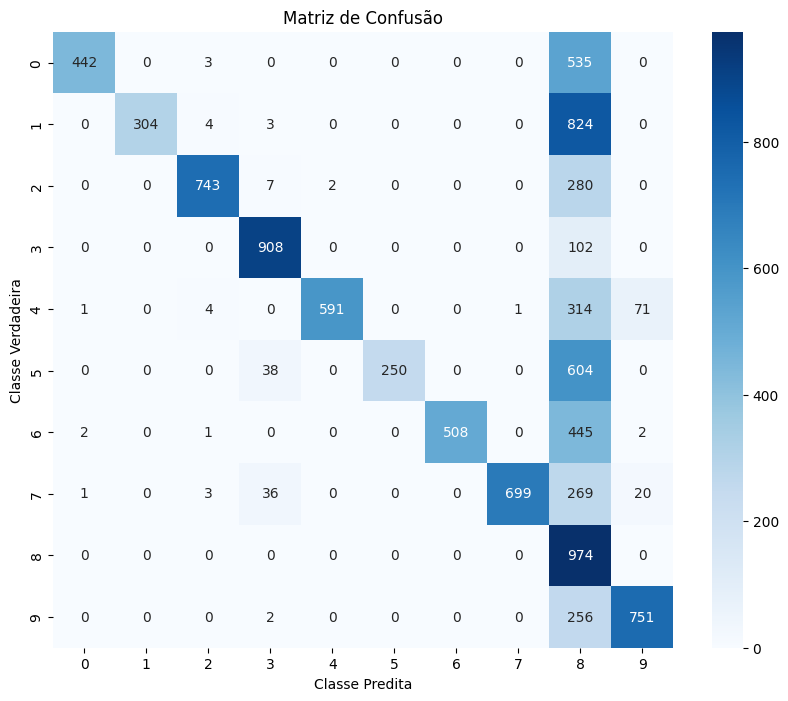

Análise das principais confusões:
A classe '0' foi confundida 0.31% das vezes com a classe '2'
A classe '0' foi confundida 54.59% das vezes com a classe '8'
A classe '1' foi confundida 0.35% das vezes com a classe '2'
A classe '1' foi confundida 0.26% das vezes com a classe '3'
A classe '1' foi confundida 72.60% das vezes com a classe '8'
A classe '2' foi confundida 0.68% das vezes com a classe '3'
A classe '2' foi confundida 0.19% das vezes com a classe '4'
A classe '2' foi confundida 27.13% das vezes com a classe '8'
A classe '3' foi confundida 10.10% das vezes com a classe '8'
A classe '4' foi confundida 0.10% das vezes com a classe '0'
A classe '4' foi confundida 0.41% das vezes com a classe '2'
A classe '4' foi confundida 0.10% das vezes com a classe '7'
A classe '4' foi confundida 31.98% das vezes com a classe '8'
A classe '4' foi confundida 7.23% das vezes com a classe '9'
A classe '5' foi confundida 4.26% das vezes com a classe '3'
A classe '5' foi confundida 67.71% das vezes c

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Certifique-se de que y_test e y_pred são rótulos inteiros (não one-hot encoded)
# Converte y_test se necessário
if len(y_test.shape) > 1 and y_test.shape[1] > 1:  # Verifica se está em one-hot encoding
    y_test = y_test.argmax(axis=1)

# Obtém predições como rótulos inteiros
y_pred = model.predict(X_test).argmax(axis=1)

# Calcula a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Exibe a matriz de confusão como um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title("Matriz de Confusão")
plt.ylabel("Classe Verdadeira")
plt.xlabel("Classe Predita")
plt.show()

# Normaliza a matriz de confusão para obter porcentagens
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Identifica as confusões mais significativas
print("Análise das principais confusões:")
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i, j] > 0:  # Ignora a diagonal principal (acertos)
            print(f"A classe '{i}' foi confundida {cm_normalized[i, j]*100:.2f}% das vezes com a classe '{j}'")

# Identifica a maior confusão para cada classe verdadeira
print("\nPrincipais confusões por classe:")
for i in range(len(cm)):
    row = cm_normalized[i, :]
    most_confused_class = np.argmax(row * (np.arange(len(cm)) != i))  # Ignora a diagonal principal
    if cm[i, most_confused_class] > 0:
        print(f"Classe '{i}' foi mais confundida com a classe '{most_confused_class}' "
              f"em {cm_normalized[i, most_confused_class]*100:.2f}% das vezes.")


Nesta etapa, realizámos uma análise detalhada da matriz de confusão para entender melhor as classificações erradas feitas pelo modelo, especificamente identificando quais classes foram mais frequentemente confundidas entre si.

A matriz de confusão, quando observada, mostra a comparação entre os rótulos verdadeiros e as previsões feitas pelo modelo. Cada valor na diagonal representa uma classificação correta, enquanto os valores fora da diagonal indicam erros de classificação. Ao analisar a matriz de confusão, observámos que, embora o modelo tenha uma alta taxa de precisão (com valores elevados na diagonal), ele tem dificuldades em distinguir certas classes, especialmente a classe 8.

**Diferença em relação a outras matrizes de confusão:**

A matriz de confusão apresentada nesta análise é diferente das anteriores por mostrar valores substanciais fora da diagonal, mas concentrados principalmente na classe 8. A classe 8 é frequentemente confundida com várias outras classes (como 0, 1, 5, 6, 7, 9), o que sugere que o modelo tem mais dificuldade em distinguir esta classe de outras. Isso pode ser devido a semelhanças visuais entre os dígitos ou a características comuns nas imagens dessas classes que o modelo não conseguiu aprender corretamente.

**O que a análise mostra:**
Erros de Classificação Frequentes: A análise revela que as classes mais frequentemente confundidas com a classe 8 incluem:

* A classe '1' foi confundida em 72.60% das vezes com a classe '8'.
* A classe '5' foi confundida em 67.71% das vezes com a classe '8'.
* A classe '6' foi confundida em 46.45% das vezes com a classe '8'.
* A classe '7' foi confundida em 26.17% das vezes com a classe '8'.
* A classe '9' foi confundida em 25.37% das vezes com a classe '8'.

**Análise das Confusões por Classe**: Cada classe apresenta uma confusão mais significativa com outra classe específica. Por exemplo, a classe '1' é maioritariamente confundida com a classe '8', o que indica que o modelo tem dificuldades em distinguir essas duas classes. Outras classes, como '4', '7' e '9', também mostram confusões significativas com a classe '8', sugerindo que o modelo pode precisar de mais exemplos ou maior diferenciação entre esses dígitos.




### 15. Visualização das Confusões Significativas com Grafo de Rede

Nesta etapa, utilizamos um grafo de rede para representar as confusões mais significativas entre as classes. O grafo permite visualizar claramente quais classes são frequentemente confundidas entre si, com a espessura das arestas (ligações entre nós) representando a intensidade da confusão, ou seja, a percentagem de vezes que uma classe foi confundida com outra.

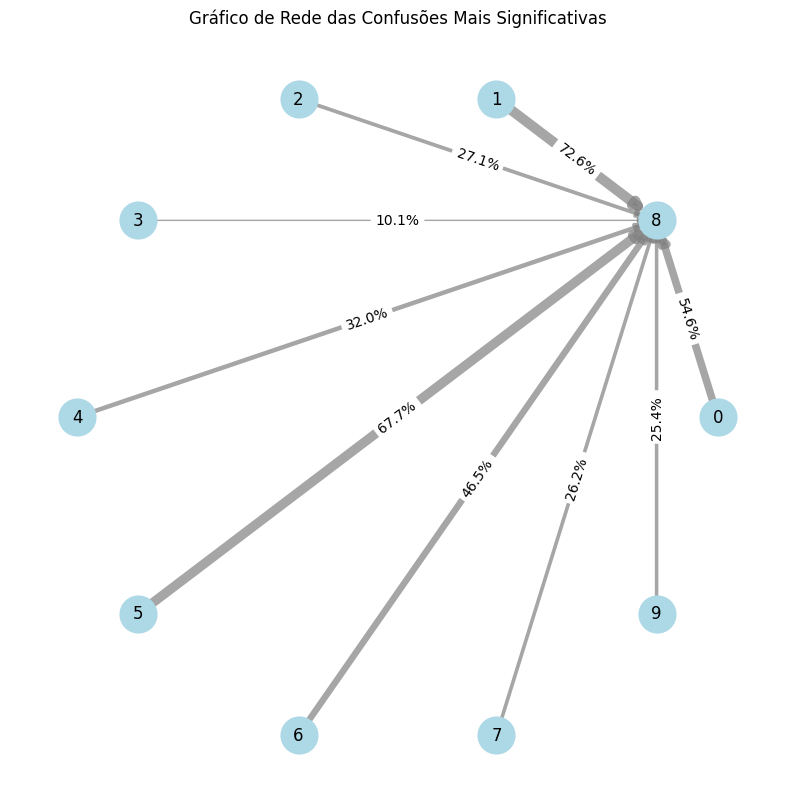

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Certifique-se de que cm_normalized foi calculado na célula anterior
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Cria um grafo para representar as confusões
G = nx.DiGraph()

# Adiciona arestas ao grafo para as confusões mais significativas
threshold = 0.1  # Limite mínimo de porcentagem para exibir conexões (10%)
for i in range(len(cm_normalized)):
    for j in range(len(cm_normalized)):
        if i != j and cm_normalized[i, j] > threshold:
            G.add_edge(i, j, weight=cm_normalized[i, j])

# Define a posição dos nós em círculo
pos = nx.circular_layout(G)

# Desenha os nós do grafo
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue")

# Desenha as arestas com espessura proporcional ao peso (confusão)
edges = G.edges(data=True)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=edges,
    width=[d['weight'] * 10 for (_, _, d) in edges],
    edge_color="gray",
    alpha=0.7,
)

# Adiciona rótulos aos nós e arestas
nx.draw_networkx_labels(G, pos, font_size=12)
edge_labels = {(u, v): f"{d['weight']*100:.1f}%" for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Gráfico de Rede das Confusões Mais Significativas")
plt.axis("off")
plt.show()


O grafo de rede fornece uma análise visual poderosa das confusões do modelo. Ao destacar a classe 8 como a mais frequentemente confundida com outras classes, conseguimos direcionar os esforços de melhoria para esse ponto específico, como ajustar o treinamento ou modificar o modelo para lidar melhor com a diferenciação entre as classes mais problemáticas. O grafo facilita a compreensão das inter-relações entre as classes e ajuda a identificar onde o modelo precisa ser melhorado.